## Introduction to Outpainting

With outpainting, you provide an image to be edited as well as a "mask" which defines which part of the image should be preserved. The mask may either be provided as a black and white image (`maskImage`) or as a natural language description of what parts of the image to retain (`maskPrompt`). Outpainting can be used to replace the background of an image, placing the image's subject in a whole new environment or special background.

### Use Case

Now, OctankFashion wants to create a professional-looking ad image featuring this new product in a realistic setting. This is often referred to as "lifestyle" imagery. The theme of the lifestyle image will be "fun at the beach". The atmosphere we want to evoke is that of a sunny day at the beach.


<div class="alert alert-block alert-warning">
<b>Prerequisites:</b> Please run the prerequiresites <b>00-prerequisites.ipynb</b> first before proceeding.
</div>


In [1]:
import io
import json
import base64
import boto3
from botocore.config import Config
from PIL import Image
from utils import save_image, plot_images

bedrock_runtime_client = boto3.client(
    "bedrock-runtime",
    region_name="us-east-1",
    config=Config(
        read_timeout=5 * 60
    ),  # IMPORTANT: Increase the read timeout to 5 minutes to support longer operations.
)
image_generation_model_id = "amazon.nova-canvas-v1:0"
output_dir = "output"

The following parameters are specific to the "OUTPAINTING" task type and are encapsulated in the `outPaintingParams` field of the request body.

- `image` (Required) – The JPEG or PNG image to modify, encoded as a Base64 string. (See code below for how to encode an image as Base64.)
- You must define one of the following fields (but not both) in order to specify the area of the image to affect:
  - `maskPrompt` – A natural language text prompt that describes the region(s) of the image to edit.
  - `maskImage` – A black and white image in which pure black pixels indicate the area inside the mask and pure white pixels indicate the area outside the mask. The mask image must be the same dimensions at the input image. Its dimensions must match the dimensions of the input `image`.
- `outPaintingMode` – There are two outpainting modes which determine how the mask you provide is interpreted.
  - “DEFAULT” – This mode transitions smoothly between the masked area and non-masked area, using some of the pixels of the original background as the starting point for the new background. This mode is often best when you would like the new background to use similar colors as the original background near the edges of your mask, but can result in a halo effect if your prompt calls for a new background that will be very different from the original background.
  - “PRECISE” – This mode adheres strictly to the mask’s bounds and is often the best option when you are making more significant changes to the background of your image.

The input image and mask image can be of any resolution that meets these requirements:

- Each side's length is no shorter than 320 and no longer than 4096
- The aspect ratio ranges from 1:4 (portrait) through 4:1 (landscape)
- The total number of pixels (width x height) does not exceed 4,194,304 (the equivalent of 2048 x 2048)
- The `image` and `maskImage` must have the same resolution


#### Example 1: Replace background with mask prompt


Outpaint is a powerful tool when you need to replace the background of one image. As with inpainting, you can choose to provide a mask prompt or mask image to help model identify the region that it should NOT reconstruct. In the example below, we'll use a mask prompt.

The best practice when writing a text prompt for background replacement is to describe the _whole_ image that you want to create, including the elements that aren't changing. This gives the model the full context of the scene and results in a more cohesive image.

Run the cells below to replace the background of the image. The generated image will be saved to the "output" folder.


In [2]:
# Define the main input parameters.
reference_image_path = "images/tshirt_palm_tree.png"
mask_prompt = "shirt"

text = "a man with tanned skin stands on a beautiful sandy beach wearing a t-shirt, clear sky and surf in the background"
outpainting_mode = "PRECISE"  # Either "DEFAULT" or "PRECISE"

seed = 97

Generating image...
Image saved to output/03-outpainting_mask-prompt.png


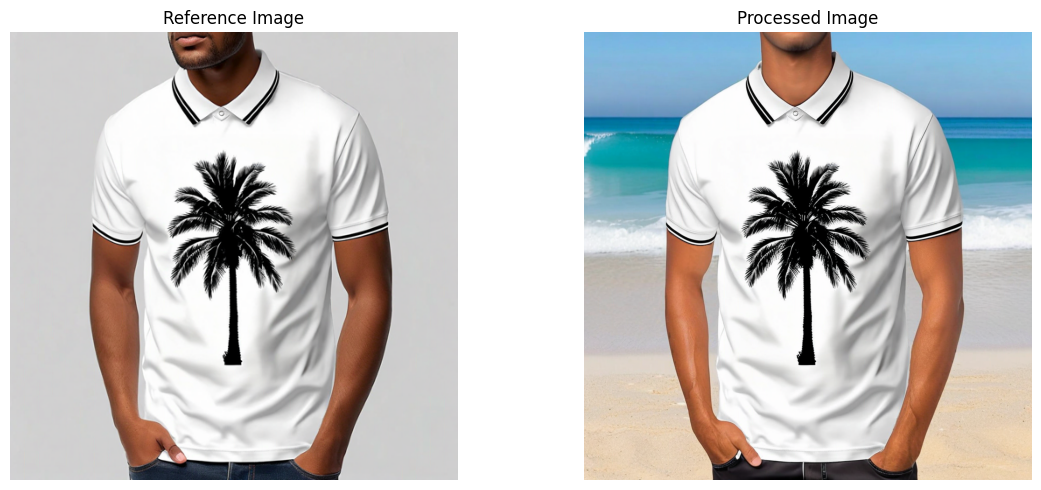

In [3]:
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": text,  # A description of the final desired image
            "image": reference_image_base64,  # The image to edit
            "maskPrompt": mask_prompt,  # One of "maskImage" or "maskPrompt" is required
            "outPaintingMode": outpainting_mode,  # Either "DEFAULT" or "PRECISE"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Number of images to generate, up to 5.
            "cfgScale": 6.5,  # How closely the prompt will be followed
            "seed": seed,  # Any number from 0 through 858,993,459
            "quality": "standard",  # Either "standard" or "premium". Defaults to "standard".
        },
    }
)

print("Generating image...")

response = bedrock_runtime_client.invoke_model(
    body=body,
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body = json.loads(response.get("body").read())

base64_images = response_body.get("images")
image_path = f"{output_dir}/03-outpainting_mask-prompt.png"
save_image(base64_images[0], image_path)

print(f"Image saved to {image_path}")

response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in base64_images
]

plot_images(response_images, ref_image_path=reference_image_path)

Generating image...
Image saved to output/03-outpainting_mask-prompt_trydefault.png


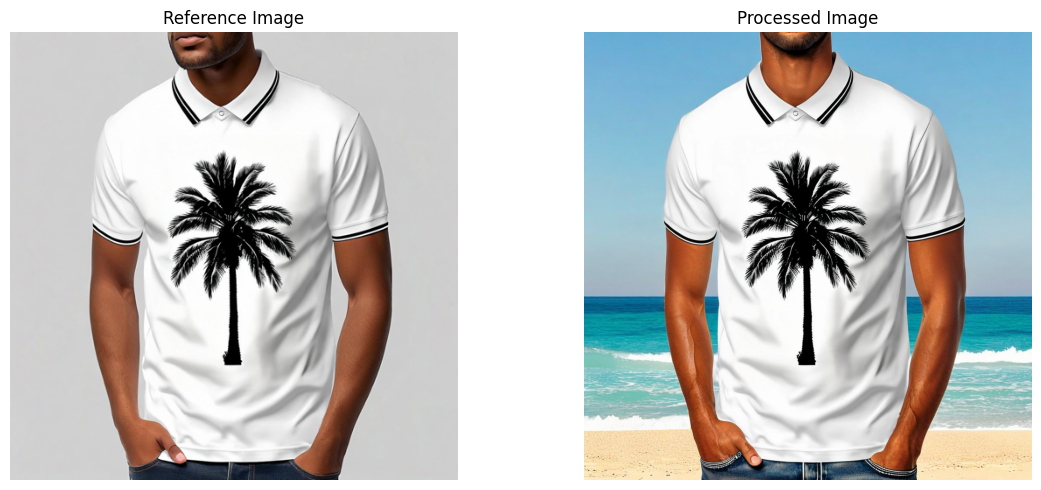

In [4]:
outpainting_mode = "DEFAULT"  # Either "DEFAULT" or "PRECISE"
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": text,  # A description of the final desired image
            "image": reference_image_base64,  # The image to edit
            "maskPrompt": mask_prompt,  # One of "maskImage" or "maskPrompt" is required
            "outPaintingMode": outpainting_mode,  # Either "DEFAULT" or "PRECISE"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Number of images to generate, up to 5.
            "cfgScale": 6.5,  # How closely the prompt will be followed
            "seed": seed,  # Any number from 0 through 858,993,459
            "quality": "standard",  # Either "standard" or "premium". Defaults to "standard".
        },
    }
)

print("Generating image...")

response = bedrock_runtime_client.invoke_model(
    body=body,
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body = json.loads(response.get("body").read())

base64_images = response_body.get("images")
image_path = f"{output_dir}/03-outpainting_mask-prompt_trydefault.png"
save_image(base64_images[0], image_path)

print(f"Image saved to {image_path}")

response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in base64_images
]

plot_images(response_images, ref_image_path=reference_image_path)

<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Outpainting supports two values for the `outpaintingMode` — "DEFAULT" and "PRECISE". Try both <tt>outpaintingMode</tt> values to observe their effect.
</div>


#### Example 2: Image extension


Often times, a creator may want to further extend the bounds of an image to satisfy the desired composition or aspect ratio. This is where image extension comes into play, allowing users to seamlessly expand the boundaries of their original image.

Let's expand the image to make it ultra wide. We'll position the original image to the right of the expanded image so that we leave plenty of room for the OctankFashion copy writers to add advertising text.

The following code is more advanced than the previous examples you've seen so far. Here are the steps the code performs:

1. Uses an image library (Pillow) to expand the bounds of the original image to match our desired resolution, filling the new expanded area with solid color pixels. (See the first image below.)
2. Uses the same image library to create a mask image which protects the original image pixels from changing. (See the second image below.)
3. Uses Nova Canvas outpainting to replace the expanded area with visuals matching your prompt.

<img src="images/03-outpainting_extension-source.png" width="48%" style="margin: 4px;"><img src="data/03-outpainting_extension-mask.png" width="48%" style="margin: 4px;border: 1px solid #99999955">

Run the cells below to create an expanded version of the original image. The generated images will be saved to the "output" folder.


In [5]:
# Define the main input parameters.
reference_image_path = "images/tshirt_beach_1024x1024.png"
text = "a man with tanned skin stands on a beautiful sandy beach wearing a t-shirt, clear sky and surf in the background"
seed = 95

# Extension settings
target_width = 2048
target_height = 1024
horizontal_position_percent = 1.0  # Position the original image at far right
vertical_position_percent = 0.5  # Center vertically

Generating image...
Image saved to output/03-outpainting_extended-image.png


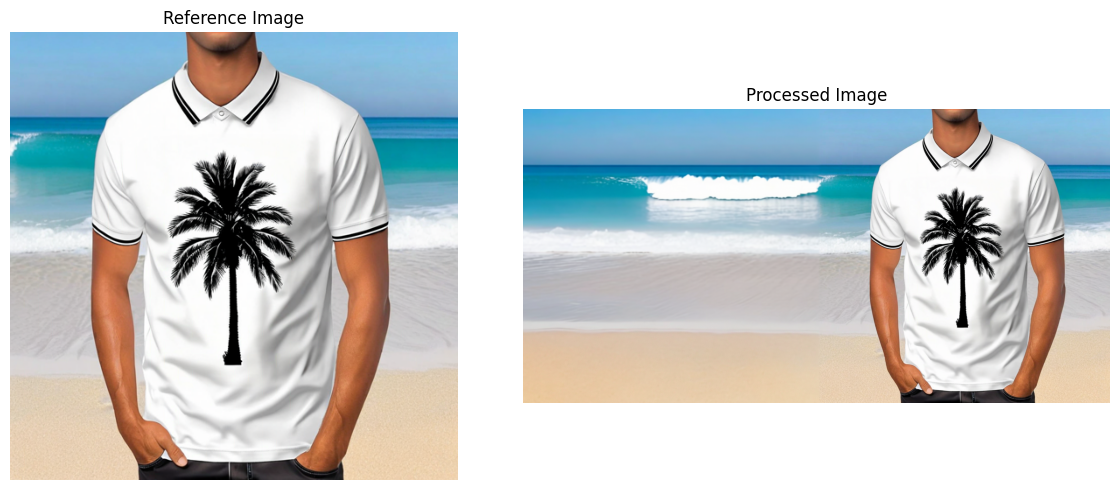

In [6]:
def convertImageToPngBase64(image):
    """
    Converts an image to PNG format and returns the base64-encoded
    representation of that PNG.
    """
    mem_file = io.BytesIO()
    image.save(mem_file, format="PNG")
    mem_file.seek(0)
    png_bytes = mem_file.read()

    return base64.b64encode(png_bytes).decode("utf-8")


# Load reference image
original_image = Image.open(reference_image_path)
original_width, original_height = original_image.size

# Calculate the position of the original image on the expanded canvas.
position = (
    int((target_width - original_width) * horizontal_position_percent),
    int((target_height - original_height) * vertical_position_percent),
)

# Create an input image which contains the original image with an expanded
# canvas. Save it for future reference.
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
input_image = Image.new("RGB", (target_width, target_height), (230, 230, 230))
input_image.paste(original_image, position)
expanded_image_base64 = convertImageToPngBase64(input_image)

# Create mask that matches the canvas size and masks the place where the
# original image is positioned.
mask_image = Image.new("RGB", (target_width, target_height), WHITE)
original_image_shape = Image.new("RGB", (original_width, original_height), BLACK)
mask_image.paste(original_image_shape, position)
mask_image_base64 = convertImageToPngBase64(mask_image)

# Save the expanded image and image mask for demonstratoin.
input_image.save("output/03-outpainting_extension-source.png")
mask_image.save("output/03-outpainting_extension-mask.png")

# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": text,
            "image": expanded_image_base64,
            "maskImage": mask_image_base64,
            "outPaintingMode": "DEFAULT",
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "seed": seed,
            "quality": "standard",
            "cfgScale": 6.5,
        },
    }
)

print("Generating image...")

response = bedrock_runtime_client.invoke_model(
    body=body,
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body = json.loads(response.get("body").read())

base64_images = response_body.get("images")
image_path = f"{output_dir}/03-outpainting_extended-image.png"
save_image(base64_images[0], image_path)

print(f"Image saved to {image_path}")

response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

plot_images(response_images, ref_image_path=reference_image_path)

## Take Away

Outpainting is a versatile image manipulation technique that extends the capabilities of traditional editing tools. This feature allows users to replace backgrounds or seamlessly expand the boundaries of existing images with remarkable ease. By intelligently generating content beyond the original image borders, outpainting enables creators to extend scenes, add new elements, or completely transform the context of an image. Whether you're looking to widen a landscape photo, adapt an image to different aspect ratios, or replace a mundane background with something more exciting, outpainting offers a powerful solution.
